In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy import stats
import statsmodels.stats.multicomp as mc

from statannotations.Annotator import Annotator

In [2]:
mpl.rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 
                     'axes.titlesize':14, 'axes.labelsize':16}) #default font sizes for plots

# Auxiliary functions

In [7]:
def compute_score(df):
    return scipy.stats.pearsonr(df.y_true,df.y_pred)[0]

def get_best_models(df, alpha=0.05):
    
    error = (df.y_true-df.y_pred)**2 #squared residuals  

    comp1 = mc.MultiComparison(error, df['model'])
    tbl, a1, a2 = comp1.allpairtest(stats.wilcoxon, method= "bonf") #Wilcoxon test with Bonferroni correction

    models_stats = pd.DataFrame(a2).set_index(['group1','group2']) #see if the difference between pairs of models is significant
    
    #we ignore default Bonferroni correction as it is for wrong number of pairs in the study
    models_stats.reject = models_stats.pval<alpha

    per_model_scores = df.groupby('model').apply(compute_score).sort_values(ascending=False) #compute score based on all predictions for a given model

    sorted_models = per_model_scores.keys() #get models ranking list, scoring in descending order

    best_models = [sorted_models[0]] #always include best model

    #loop over the list and add models until the difference between current and subsequent models is significant
    for model_idx in range(len(sorted_models)-1):

        #two keys are possible for a given pair of models
        idx_2models = (sorted_models[model_idx], sorted_models[model_idx+1]) 
        idx_2models_swap = (sorted_models[model_idx+1], sorted_models[model_idx])

        if ((idx_2models in models_stats.index and models_stats.loc[idx_2models].reject==False) 
                or (idx_2models_swap in models_stats.index and models_stats.loc[idx_2models_swap].reject==False)):
                    best_models.append(sorted_models[model_idx+1])
        else:
            #as soon as significant difference is detected, dont add models to the best models list
            break
            
    return best_models

def highlight_ns(x, best_models):
    #make the best model and models with insignificant difference with the best model bold
    cell_type, response = x.name
    return ['font-weight: bold' if model in best_models[(cell_type,response)] else ''
                for model in x.index]

# Collect predictions

In [8]:
data_dir = '/s/project/mll/sergey/effect_prediction/MLM/siegel_2022/SVR/'

In [9]:
models = ['MLM','4mers','5mers','word2vec','effective_length']

In [10]:
res = {}

for response in ('stability', 'steady_state'):
    for cell_type in ('Jurkat', 'Beas2B'):
        res[(response,cell_type)] = []
        for model in models:
            res_tsv = data_dir + f'{cell_type}-{response}-{model}.tsv'
            if os.path.isfile(res_tsv):
                df = pd.read_csv(res_tsv, sep='\t', skiprows=1, usecols=[2,7,8,36,38,39],names=['ids','iscontrol','parent_control_oligo','y_true','chrom','y_pred'])
                df['model'] = model
                res[(response,cell_type)].append(df)
        if len(res[(response,cell_type)])>0:
            res[(response,cell_type)] = pd.concat(res[(response,cell_type)])

# Visualize per fold scores

In [11]:
per_fold_scores = res[('stability','Jurkat')].groupby(['model','chrom']).apply(compute_score).rename('score')

In [12]:
per_fold_scores = per_fold_scores.reset_index().sort_values(by=['model','chrom'])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MLM vs. 4mers: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:4.530e-06 Stat=7.000e+00
MLM vs. 5mers: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.192e-06 Stat=3.000e+00
MLM vs. word2vec: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:5.517e-04 Stat=3.100e+01
MLM vs. effective_length: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:5.625e-02 Stat=7.500e+01


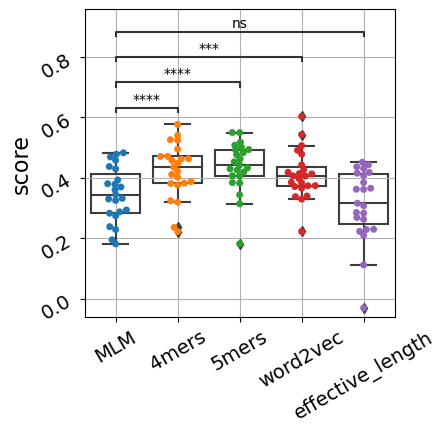

In [13]:
fig, ax = plt.subplots(figsize=(4,4))

ax = sns.swarmplot(data=per_fold_scores, x="model", y="score", order=models, ) #scatter plot
ax = sns.boxplot(data=per_fold_scores, x="model", y="score", order=models, boxprops={'facecolor':'None'})

box_pairs=[ ('MLM', '4mers'), ('MLM', '5mers'),('MLM', 'word2vec'),('MLM', 'effective_length')]

annotator = Annotator(ax, box_pairs, data=per_fold_scores, x="model", y="score", order=models)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction="BH")
#annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="BH")

annotator.apply_and_annotate()

ax.set_xlabel("")
ax.set_ylabel("score")
ax.tick_params(rotation=30)
ax.grid()

# Stability and Steady state prediction

In [14]:
preds_res = {}
best_models = {}

alpha = 0.05/(5*2*2) #significance level with Bonferroni correction (5 models x 2 cell types x 2 response types)

for cell_type in ('Jurkat', 'Beas2B'):
    
    for response in ('steady_state','stability'):
        
        #per_fold_scores = res[(response,cell_type)].groupby(
        #    ['model','chrom']).apply(compute_score).rename('score').reset_index()
        
        #preds_res[(cell_type,response)] = per_fold_scores.groupby('model').score.mean()
        
        preds_res[(cell_type,response)] = res[(response,cell_type)].groupby('model').apply(compute_score)
        best_models[(cell_type,response)] = get_best_models(res[(response,cell_type)], alpha=alpha)
        
preds_res = pd.DataFrame(preds_res).applymap(lambda x:f'{x:.2f}')

preds_res.loc[models].round(2).style.apply(lambda x: highlight_ns(x, best_models))

# Differential expression

'To predict the effect of mutations, we simply subtract the18
predicted expression or decay time of the wild-type from the19
predicted expression or decay time of the mutant; we do not20
train and test on the difference data directly.'

see Siegel, David A., et al. "Massively parallel analysis of human 3′ UTRs reveals that AU-rich element length and registration predict mRNA destabilization." G3 12.1 (2022): jkab404.

Rabani, Michal, et al. "A massively parallel reporter assay of 3′ UTR sequences identifies in vivo rules for mRNA degradation." Molecular cell 68.6 (2017): 1083-1094.

In [93]:
preds_res = {}
best_models = {}

alpha = 0.05/(5*2*2) #significance level with Bonferroni correction (5 models x 2 cell types x 2 response types)

for cell_type in ('Jurkat', 'Beas2B'):
    
    for response in ('steady_state','stability'):
        
        df = res[(response,cell_type)]

        ref_df = df[df.iscontrol==1]
        alt_df = df[df.iscontrol==0]

        delta_df = alt_df.merge(ref_df, on =['parent_control_oligo','model'], suffixes=('_alt','_ref'))

        delta_df['y_true'] = delta_df.y_true_alt - delta_df.y_true_ref
        delta_df['y_pred'] = delta_df.y_pred_alt - delta_df.y_pred_ref

        delta_df = delta_df[~delta_df.y_true.isna()]

        preds_res[(cell_type,response)] = delta_df.groupby('model').apply(compute_score)
        best_models[(cell_type,response)] = get_best_models(delta_df, alpha=alpha)

preds_res = pd.DataFrame(preds_res).applymap(lambda x:f'{x:.2f}')
preds_res.loc[models].round(2).style.apply(lambda x: highlight_ns(x, best_models))